## Comparing Models
We want to compare **four approaches** to modeling our data from *control* and *mutant* mice.
The idea is to show that a **full regression model with group and slope terms** outperforms simple means or partial models.


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

### **1. Data Setup**

We have:

* A **binary group variable**:

  $$
  \text{group} =
  \begin{cases}
  0 & \text{Control mice} \\
  1 & \text{Mutant mice}
  \end{cases}
  $$
* A **continuous predictor** $x$ (e.g., age, weight, dosage).
* A **response variable** $y$ (e.g., measured outcome).

In [14]:
groups = np.array(['Control'] * 4 + ['Mutant'] * 4)
weights = np.array([21.0, 19.5, 20.2, 20.7, 24.8, 25.1, 23.9, 24.4])

df = pd.DataFrame({'Group': groups, 'Weight': weights})
df['Mutant'] = (df['Group'] == 'Mutant').astype(int)
df['x'] = np.arange(len(df))

<Figure size 600x400 with 0 Axes>

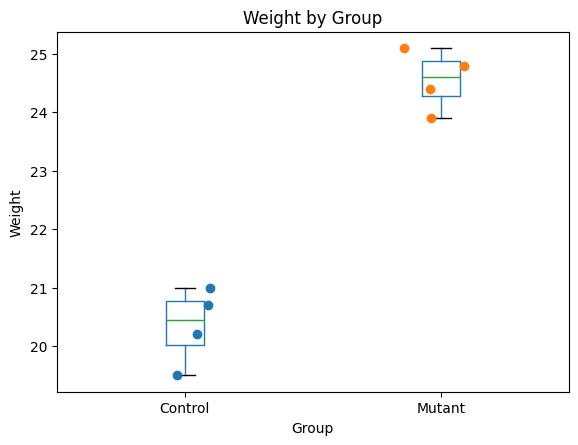

In [15]:
plt.figure(figsize=(6, 4))
ax = df.boxplot(column='Weight', by='Group', grid=False)
for i, g in enumerate(df['Group'].unique()):
    y = df.loc[df['Group']==g, 'Weight']
    x = np.random.normal(i+1, 0.05,size=len(y))
    plt.plot(x, y, 'o')
plt.suptitle('')
plt.title('Weight by Group')
plt.xlabel('Group')
plt.ylabel('Weight')
plt.show()

## **2. Models to Compare**

### **Model A: Mean Only**

This is the simplest possible model:

$$
y = \mu + \varepsilon
$$

where $\mu$ is just the overall mean of all data points.
No group information, no slope — **same prediction for everyone**.

In [16]:
X_mean = np.ones(len(df))
model_mean = sm.OLS(df['Weight'], X_mean).fit()
print(model_mean.summary())

                            OLS Regression Results                            
Dep. Variable:                 Weight   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 12 Aug 2025   Prob (F-statistic):                nan
Time:                        16:09:34   Log-Likelihood:                -17.518
No. Observations:                   8   AIC:                             37.04
Df Residuals:                       7   BIC:                             37.12
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.4500      0.817     27.478      0.0

/Users/aarshitaacharya/.pyenv/versions/3.10.16/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=8 observations were given.
  return hypotest_fun_in(*args, **kwds)



### **Model B: Intercept + Slope (No Group Info)**

Here we fit a straight line to **all mice pooled together**:

$$
y = \beta_0 + \beta_1 x + \varepsilon
$$

Still ignores the group difference — assumes **both control and mutant follow the same line**.


In [17]:
df['Index'] = np.arange(len(df))
X_slope = sm.add_constant(df['Index'])
model_slope = sm.OLS(df['Weight'], X_slope).fit()
print(model_slope.summary())


                            OLS Regression Results                            
Dep. Variable:                 Weight   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     11.89
Date:                Tue, 12 Aug 2025   Prob (F-statistic):             0.0137
Time:                        16:09:34   Log-Likelihood:                -13.149
No. Observations:                   8   AIC:                             30.30
Df Residuals:                       6   BIC:                             30.46
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.7583      0.933     21.173      0.0

/Users/aarshitaacharya/.pyenv/versions/3.10.16/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=8 observations were given.
  return hypotest_fun_in(*args, **kwds)


### **Model C: Mean Control + t-test for Difference**

This is the classic **two-sample t-test** setup:

1. Compute the mean for **control** group: $\mu_c$
2. Compute the mean for **mutant** group: $\mu_m$
3. Difference:

$$
\Delta = \mu_m - \mu_c
$$

4. Test:

$$
t = \frac{\Delta}{SE(\Delta)}
$$

This tests whether the **two group means are significantly different** (no slope term).


In [18]:
df['Mutant'] = (df['Group'] == 'Mutant').astype(int)
X_diff = sm.add_constant(df['Mutant'])
model_diff = sm.OLS(df['Weight'], X_diff).fit()
print(model_diff.summary())


                            OLS Regression Results                            
Dep. Variable:                 Weight   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     100.8
Date:                Tue, 12 Aug 2025   Prob (F-statistic):           5.66e-05
Time:                        16:09:34   Log-Likelihood:                -6.0015
No. Observations:                   8   AIC:                             16.00
Df Residuals:                       6   BIC:                             16.16
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.3500      0.296     68.796      0.0

/Users/aarshitaacharya/.pyenv/versions/3.10.16/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=8 observations were given.
  return hypotest_fun_in(*args, **kwds)


### **Model D: Full Regression Model (Group + Slope)**

This is the **design matrix** approach:

$$
y = \beta_0 + \beta_g \cdot \text{group} + \beta_1 x + \varepsilon
$$

Where:

* $\beta_0$: intercept for **control group** (when $x = 0$)
* $\beta_g$: **offset** for mutant group (difference in intercept between mutant and control)
* $\beta_1$: slope shared by both groups
  (or you could extend to have **different slopes per group** if interaction is included)

**Interpretation:**

* $\beta_g$ tells you how much higher/lower mutants are compared to controls **after adjusting for x**.
* The model uses **all data at once**, making it more powerful than a separate mean or t-test.


In [19]:
X_full = sm.add_constant(df[['Mutant', 'Index']])
model_full = sm.OLS(df['Weight'], X_full).fit()
print(model_full.summary())


                            OLS Regression Results                            
Dep. Variable:                 Weight   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     45.89
Date:                Tue, 12 Aug 2025   Prob (F-statistic):           0.000607
Time:                        16:09:34   Log-Likelihood:                -5.6659
No. Observations:                   8   AIC:                             17.33
Df Residuals:                       5   BIC:                             17.57
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.5450      0.428     47.968      0.0

/Users/aarshitaacharya/.pyenv/versions/3.10.16/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=8 observations were given.
  return hypotest_fun_in(*args, **kwds)


In [20]:
print("Mean-only AIC:", model_mean.aic)
print("Slope AIC:", model_slope.aic)
print("Diff AIC:", model_diff.aic)
print("Full AIC:", model_full.aic)


Mean-only AIC: 37.036570614055414
Slope AIC: 30.29872058314352
Diff AIC: 16.002982955671108
Full AIC: 17.331788225407102
